In [ ]:
# 实现 ARMA模型预测（专业课）
# 使用discover数据集或自己收集的本专业相关数据、构建相应的AR、MA或ARMA模型，预测出之后至少10个步长的数据值，并将预测值与真实值进行对比。
# 实验应至少包括：数据预处理、数据可视化、模型的识别与定阶、模型预测、预测值与真实值对比图。

In [18]:
# 获取数据
import tushare as ts
# 设置token
ts.set_token('7424c7ac953aebbb54e59f2624b47d5333cec6e3744bc0556a5c7538')
# 初始化pro接口
pro = ts.pro_api()
# 根据时间段获取日交易数据, 000001招商银行, 时间段为：2010年1月1日-2020年1月1日
data = pro.daily(ts_code='000001.SZ', start_date='20100101', end_data='20200101')
data.sort_values(by='trade_date', inplace=True)
data.reset_index(drop=True, inplace=True)
# 输出数据
data

,ts_code,trade_date,open,high,low,close,pre_close,change,pct_chg,vol,amount
0,000001.SZ,20100104,24.52,24.58,23.68,23.71,24.37,-0.66,-2.7100,241922.76,5.802495e+05
1,000001.SZ,20100105,23.75,23.90,22.75,23.30,23.71,-0.41,-1.7300,556499.82,1.293477e+06
2,000001.SZ,20100106,23.25,23.25,22.72,22.90,23.30,-0.40,-1.7200,412143.13,9.444537e+05
3,000001.SZ,20100107,22.90,23.05,22.40,22.65,22.90,-0.25,-1.0900,355336.85,8.041663e+05
4,000001.SZ,20100108,22.50,22.75,22.35,22.60,22.65,-0.05,-0.2200,288543.06,6.506674e+05
...,...,...,...,...,...,...,...,...,...,...,...
2677,000001.SZ,20210423,23.32,23.65,23.07,23.29,22.98,0.31,1.3490,823230.15,1.920414e+06
2678,000001.SZ,20210426,23.87,24.23,22.90,22.94,23.29,-0.35,-1.5028,872417.67,2.037110e+06
2679,000001.SZ,20210427,22.95,23.19,22.86,22.94,22.94,0.00,0.0000,470431.40,1.083044e+06
2680,000001.SZ,20210428,23.29,23.45,22.78,23.35,22.94,0.41,1.7873,593837.93,1.375141e+06


In [25]:
# 一、数据预处理
# 时间序列预处理：平稳性检验
from statsmodels.tsa.stattools import adfuller as ADF
diff=0
# print(data['close'])
adf=ADF(data['close'])
# print(adf)
if adf[1]>0.05:
    print(u'原始序列经检验不平稳,p值为:%s' %(adf[1]))
else:
    print(u'原始序列经检验平稳,p值为:%s' %(adf[1]))

原始序列经检验不平稳,p值为:0.08572163250370107


In [31]:
# 时间序列预处理：纯随机性检验
from statsmodels.stats.diagnostic import acorr_ljungbox
[[lb],[p]]=acorr_ljungbox(data['close'], lags=1,return_df=False)
if p<0.05:
    print(u'原始序列为非白噪声序列,p值为:%s'%p)
else:
    print(u'原始序列为白噪声序列,p值为:%s' %p)

原始序列为非白噪声序列,p值为:0.0


In [36]:
# 二、数据可视化
import matplotlib.pyplot as plt
data = data[['close']] # open开盘价, close收盘价, high最高价, low最低价
print(data)
# data.plot(subplots=True, figsize=(20, 12))
# plt.title('000001 stock attributes from 2010-01-01 to 2020-01-01')
# # plt.savefig('stocks.png')
# plt.show()

      close
0     23.71
1     23.30
2     22.90
3     22.65
4     22.60
...     ...
2677  23.29
2678  22.94
2679  22.94
2680  23.35
2681  23.59

[2682 rows x 1 columns]


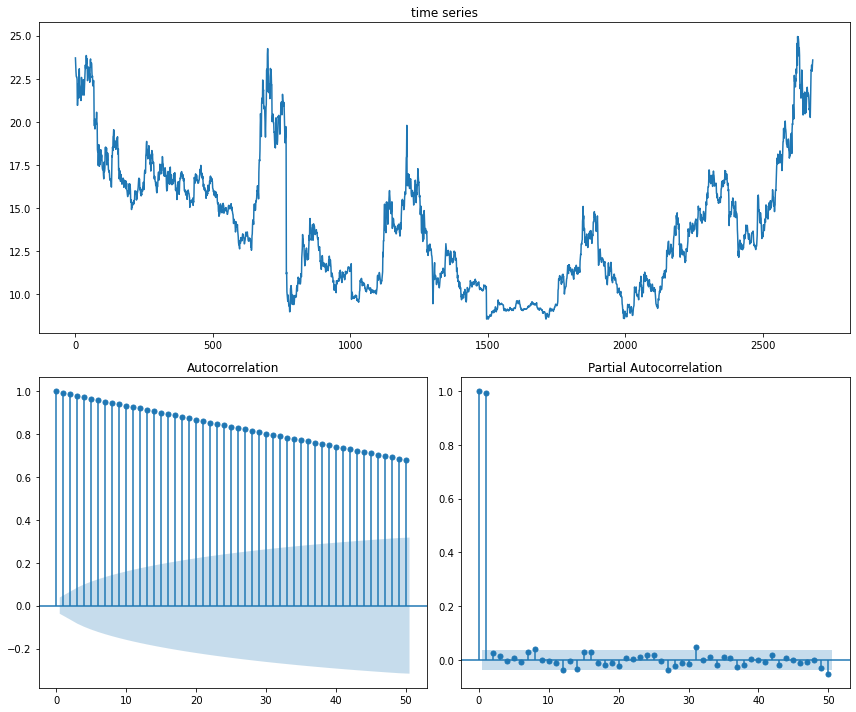

In [42]:
# 三、模型的识别与定阶
import pandas as pd
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

def plotds(xt, nlag=30, fig_size=(12, 10)):
    if not isinstance(xt, pd.Series):
        xt = pd.Series(xt)
    plt.figure(figsize=fig_size)
    layout = (2, 2)
    
    # 设置画图布局
    ax_xt = plt.subplot2grid(layout, (0, 0), colspan=2) #最上面是xt图
    ax_acf = plt.subplot2grid(layout, (1, 0)) # 左下角是acf图
    ax_pacf = plt.subplot2grid(layout, (1, 1)) # 右下角是pacf图
    
    # 画出原始序列图像、自相关函数图像、偏相关函数图像
    xt.plot(ax=ax_xt)
    ax_xt.set_title('time series')
    plot_acf(xt, lags=nlag, ax=ax_acf)
    plot_pacf(xt, lags=nlag, ax=ax_pacf)
    plt.tight_layout()

plotds(data['close'].dropna(), nlag=50)

In [59]:
# 由上述ACF和PACF图已知，自相关函数是拖尾的，偏相关函数也是拖尾的，所以要选择ARMA模型，并需要进一步确定模型阶数
import statsmodels.tsa.api as smtsa
# 导入warnings，忽略warnings
import warnings
warnings.filterwarnings('ignore')

data_df=data.copy()
aicVal=[]
for ari in range(1, 3):
    for maj in range(0, 5):
        try:
            arma_obj = smtsa.ARMA(data_df.close.tolist(), order=(ari, maj)).fit(maxlag=30, method='mle', trend='nc')
            aicVal.append([ari, maj, arma_obj.aic])
        except Exception as e:
            print(e)
# 输出aicVal
aicVal


[[1, 0, 2335.540579146762],
 [1, 1, 2336.1044997078216],
 [1, 2, 2338.0627775868825],
 [1, 3, 2339.707514765354],
 [1, 4, 2340.661436977658],
 [2, 0, 2336.1171033387645],
 [2, 1, 2338.0817447767495],
 [2, 2, 2334.338793626569],
 [2, 3, 2336.0399485939706],
 [2, 4, 2337.9654984157696]]

In [62]:
# 模型拟合结果展示
from statsmodels.tsa.arima.model import ARIMA

# method=mle 使用最大似然参数估计方法
# order=(2,2) 代表模型阶数
# trend=nc 控制确定性趋势的参数
arma_obj_fin = smtsa.ARMA(data_df.close.tolist(), order=(2,2)).fit(maxlag=30, method='mle', trend='nc', disp=False)

arma_obj_fin.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:                      y   No. Observations:                 2682
Model:                     ARMA(2, 2)   Log Likelihood               -1162.169
Method:                           mle   S.D. of innovations              0.373
Date:                Thu, 29 Apr 2021   AIC                           2334.339
Time:                        17:06:48   BIC                           2363.810
Sample:                             0   HQIC                          2345.000
                                                                              
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1.y        0.0546        nan        nan        nan         nan         nan
ar.L2.y        0.9452        nan        nan        nan         nan         nan
ma.L1.y        0.9247      0.013     69.170      0.000       0.898       0.951
ma.L2.y       -0.0349      0.019     -1.833      0.067      -0.072       0.002
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            1.0001           +0.0000j            1.0001            0.0000
AR.2           -1.0579           +0.0000j            1.0579            0.5000
MA.1           -1.0406           +0.0000j            1.0406            0.5000
MA.2           27.5007           +0.0000j           27.5007            0.0000
-----------------------------------------------------------------------------
"""

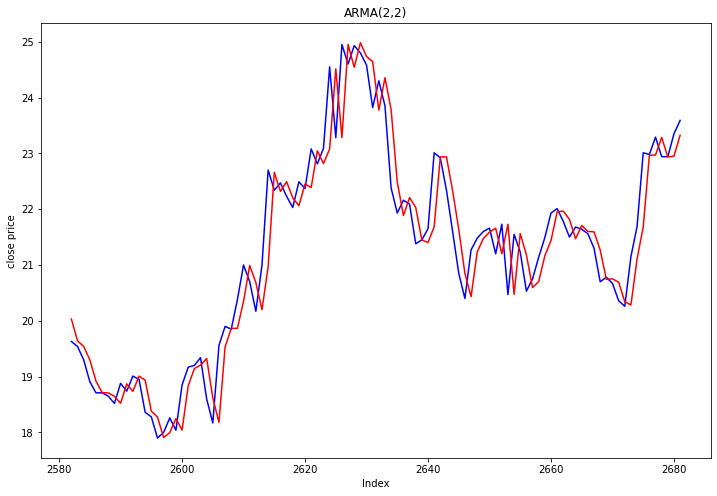

In [64]:
# 四、模型预测 预测值与真实值对比
data_df['ARMA'] = arma_obj_fin.predict()  # 将拟合结果存储到data_df变量，列名命名为ARMA
f, axarr = plt.subplots(1, sharex=True)
f.set_size_inches(12, 8)

data_df['close'].iloc[len(data_df)-100:].plot(color='b', linestyle='-', ax=axarr)  # 真实数据图像
data_df['ARMA'].iloc[len(data_df)-100:].plot(color='r', linestyle='-', ax=axarr)  # 拟合数据图像 
axarr.set_title('ARMA(2,2)')  # 设置标题
plt.xlabel('Index')
plt.ylabel('close price')
plt.show()

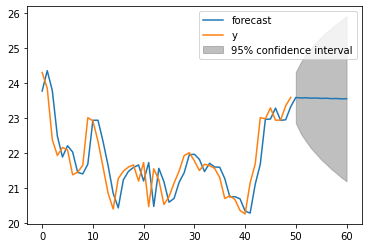

In [91]:
#fig = arma_obj_fin.plot_predict(len(data_df)-50, len(data_df)+10)
#print(len(data_df))
fig = arma_obj_fin.plot_predict(len(data_df)-50, len(data_df)+10)

In [99]:
# 预测结果数值展示
#predict = arma_obj_fin.predict(start=1, end=len(data_df)+10)
predict = arma_obj_fin.predict(len(data_df)-50, len(data_df)+10)
predict[len(predict)-10:]

array([23.5740859 , 23.58057265, 23.56791287, 23.57335302, 23.56168444,
       23.56618949, 23.55540671, 23.55907627, 23.54908512, 23.55200822])